В этой работе нам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
print(df.shape[0])

33444


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



##Подготовка

Целевая переменная находится в колонке `Sentiment`.  Преобразуем ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [ ]:
df['Sentiment'].unique() # ['Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']

df['Sentiment'] = [1 if 'Positive' in sentiment else 0 for sentiment in df['Sentiment']]
df.head(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
1,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
2,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
3,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",0


Сбалансированы ли классы?

In [ ]:
df['Sentiment'].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

Классы весьма сбалансированы. Разница в 2648 твитов незначительная при таком количестве объектов.

Выведем на экран информацию о пропусках в данных. Если пропуски присутствуют, заполним их строкой 'Unknown'.

In [ ]:
df.isna().any() # Location -- True, остальные False
df['Location'] = ['Unknown' if pd.isna(location) else location for location in df['Location']]
df.isna().any().any() # False

False

Разделим данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)
# test_size=0.3 указывает, что 30% данных будут использоваться для тестовой выборки,
# а оставшиеся 70% — для обучающей выборки.

## Токенизация

Построем словарь на основе обучающей выборки и посчитаем количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [ ]:
import re # модуль, предназначенный для работы с регулярными выражениями
from collections import Counter # Counter -- подкласс словаря dict

# Функция для токенизации текста
def simple_tokenize(text):
    # Убираем знаки пунктуации
    text = re.sub(r'[^\w\s]', '', text)

    # Приводим каждое слово к нижнему регистру и делим по пробелу,
    # записывая в список tokens
    tokens = text.lower().split()
    # split разделяет строку по любому количеству пробелов, табуляции или переводов строк
    return tokens

word_counts = Counter()

# Подсчет слов из твитов в обучающей выборке
for tweet in train['OriginalTweet']:
    word_counts.update(simple_tokenize(tweet))

re.sub() -- это функция, которая заменяет части строки text, равные регулярному выражению r'[^\w\s]' на пустую строку, тем самым удаляя символы, обозначенные регулярным выражением.

Теперь разберем регулярное выражение r'[^\w\s]':
1.   r перед строкой указывает, что это "сырая" строка (raw string) для того, чтобы не воспринимать обратные слеши как начало специального символа.
2.   Шаблон [^\w\s] описывает класс символов, который включает в себя все символы, кроме тех, что указаны в скобках
3. \w эквивалентно [a-zA-Z0-9_].
4. \s соответствует любому пробельному символу
5. В начале класса символов ^ означает отрицание.

Таким образом, [^\w\s] соответствует любому символу, который не является буквой, цифрой, подчеркиванием или пробельным символом.




Какой размер словаря получился?

In [ ]:
len(word_counts)

56942

Размер словаря: 56942

Выведем 10 самых популярных токенов с количеством встреч каждого из них. Проанализируем, почему именно эти токены в топе.

In [ ]:
word_counts.most_common(10)

[('the', 26906),
 ('to', 23461),
 ('and', 14763),
 ('of', 13041),
 ('a', 11802),
 ('in', 11326),
 ('coronavirus', 9916),
 ('for', 8614),
 ('covid19', 7590),
 ('is', 7452)]

Разделим самые частовстречающиеся слова на две группы. Первая -- это артикли, предлоги, союз and, глагол is. Вторая: coronavirus и covid19.

Слова из первой группы будут самыми частовстречающимеся в большинстве английских текстов, потому что являются часто употребимыми для связи слов в предложения, для постановки грамотной речи.

Слова второй группы относятся к теме твитов. Это очевидно, что в твитах про коронавирус будут часто встречаться слова coronavirus и covid19.

Удалим стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.

Стоп-слова — это слова, которые часто встречаются в языке, но не несут значимой информации. Слова из первой группы выше -- это стоп-слова.

In [ ]:
import nltk
from nltk.corpus import stopwords

# Загрузка списка стоп-слов для английского языка
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

word_counts = Counter({word: count for word, count in word_counts.items() if word not in stop_words})
word_counts.most_common(10)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('coronavirus', 9916),
 ('covid19', 7590),
 ('prices', 4605),
 ('food', 4475),
 ('supermarket', 3966),
 ('store', 3853),
 ('grocery', 3581),
 ('people', 3443),
 ('amp', 3180),
 ('consumer', 2416)]

Этот набор уже более информативен. Мы видим, что людей беспокоила обстановка с ценами, доступность продуктов в супермаркетах.

people -- общее слово, которое может использоваться в различных контекстах.

Также в твитах упоминается COVID-19 AMP -- диагностическая тест-система для выявления коронавируса

Употребление слова consumer может обозначать обсуждение реакции потребителей на меры, связанные с коронавирусом.

Удаление стоп-слов помогло выявить наиболее важные темы и слова, которые действительно отражают основные аспекты дискуссий вокруг пандемии. Предобработка текста позволяет лучше понять, что конкретно беспокоит или интересует людей, исключая общие слова, которые могут мешать анализу.

Также выведем 20 самых непопулярных слов (если самых непопулярных слов больше, выведем любые 20 из них).

In [ ]:
word_counts.most_common()[-20:]

[('httpstcolw1r0rm7xs', 1),
 ('httpstco5cbliqzx7l', 1),
 ('nowwhen', 1),
 ('milion', 1),
 ('skellig', 1),
 ('skelligsix18', 1),
 ('skelligcoast2kms', 1),
 ('southkerry', 1),
 ('httpstcozjcl195vqs', 1),
 ('srinivasiyc', 1),
 ('httpstcoiaek4fwsgz', 1),
 ('premiership', 1),
 ('nonplaying', 1),
 ('subsidise', 1),
 ('playersãâ', 1),
 ('renewing', 1),
 ('flew', 1),
 ('torontopearson', 1),
 ('680news', 1),
 ('httpstco7j2y3rsld9', 1)]

Эта подборка содержит "случайно попавшие" слова, которые не несут смысловой нагрузки: слова с ошибками; возможно, упоминания других юзеров или сайтов. Отдельно работать с такими словами нет смысла.



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Применим его и посмотрим на топ-10 популярных слов.

In [ ]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()
word_counts_new = Counter()

for tweet in train['OriginalTweet']:
  word_counts_new.update(tokenizer.tokenize(tweet.lower()))

word_counts_new.most_common(10)

[('the', 26993),
 ('.', 24118),
 ('to', 23478),
 (',', 17571),
 ('and', 14825),
 ('of', 13044),
 ('a', 11891),
 ('in', 11348),
 ('?', 9524),
 ('#coronavirus', 8808)]

TweetTokenizer отделяет знаки препинания от слов и считает их отдельными токенами. С базовой настройкой TweetTokenizer не фильтрует знаки препинания, что делает полученные данные неинформативными для анализа.

Стоит заметить, что в варианте выше 'coronavirus' имеет 9916 упоминаний, а здесь не указано отдельно слово, но есть #coronavirus' с упоминание 8808 раз.

simple_tokenize (мною написанная функция) убирает все знаки препинания, в том числе '#'. В результате все упоминания "coronavirus", вне зависимости от того, были ли они частью хэштега или нет, считаются одинаково. Это приводит к большему количеству упоминаний.

С TweetTokenizer "#coronavirus" считается отдельным токеном и не суммируется с упоминаниями "coronavirus".





Удалим из словаря стоп-слова и пунктуацию, посмотрим на новый топ-10 слов с количеством встреч.

In [ ]:
from string import punctuation

word_counts_new = Counter({word: count for word, count in word_counts_new.items() if word not in stop_words and word not in punctuation})
word_counts_new.most_common(10)

[('#coronavirus', 8808),
 ('â', 7415),
 ('\x82', 7311),
 ('19', 7167),
 ('covid', 6253),
 ('prices', 4601),
 ('\x92', 4372),
 ('food', 4367),
 ('store', 3877),
 ('supermarket', 3805)]

В словаре по-прежнему есть странные экземпляры: 'â', '\x82', '\x92'. Возможно, для некоторых твитов была использована неправильная кодировка, или же это может быть отображение эмодзи, которые часто встречаются в твитах.

Удалим из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведем топ-10 самых популярных и топ-20 непопулярных слов.

In [ ]:
word_counts_new = Counter({word: count for word, count in word_counts_new.items() if len(word) != 1 or ord(word[0]) < 128})
print(word_counts_new.most_common(10))
print(word_counts_new.most_common()[-20:])

[('#coronavirus', 8808), ('19', 7167), ('covid', 6253), ('prices', 4601), ('food', 4367), ('store', 3877), ('supermarket', 3805), ('grocery', 3523), ('people', 3463), ('#covid19', 2589)]
[('https://t.co/lw1r0rm7xs', 1), ('https://t.co/5cbliqzx7l', 1), ('now.when', 1), ('milion', 1), ('skellig', 1), ('@skelligsix18', 1), ('#skelligcoast2kms', 1), ('#southkerry', 1), ('https://t.co/zjcl195vqs', 1), ('@srinivasiyc', 1), ('https://t.co/iaek4fwsgz', 1), ('premiership', 1), ('non-playing', 1), ('subsidise', 1), ('playersã', 1), ('renewing', 1), ('flew', 1), ('@torontopearson', 1), ('@680news', 1), ('https://t.co/7j2y3rsld9', 1)]


Мне кажется собственная токенизация более информативной, потому что там, например, не выделилось как отдельное слово "19", а ведь оно действительно используется в основном в контексте "covid19".

"covid19" и "#covid19" я бы тоже объединила, потому что обе эти записи имеют одинаковое значение. Но, возможно, разделение поможет при анализе дальше. Посмотрим :)

Топ-20 с конца как был странным, так и остался. Там много ссылок, которые можно проанализировать, если перейти по самым популярным (если такие имеются).

Выведем топ-10 популярных хештегов с количеством встреч.

In [ ]:
hashtags = Counter({word: count for word, count in word_counts_new.items() if '#' in word})
hashtags.most_common(10)

[('#coronavirus', 8808),
 ('#covid19', 2589),
 ('#covid_19', 1734),
 ('#covid2019', 946),
 ('#toiletpaper', 744),
 ('#covid', 641),
 ('#socialdistancing', 465),
 ('#coronacrisis', 448),
 ('#pandemic', 257),
 ('#coronaviruspandemic', 249)]

Большая часть хэштегов включает слова covid или corona(virus) что логично, ведь это ключевое слово в данной теме.

Видимо, людей беспокоил или забавил ажиотаж вокруг туалетной бумаги во время ковида, когда все запасались самым необходимым :)

Также темой для обсуждения было соблюдение социальной дистанции.

Хэштеги хорошо отражают наполнение твитов и могут выдать полезную для анализа информацию.

То же самое проделаем для ссылок на сайт https://t.co

In [ ]:
links = Counter({word: count for word, count in word_counts_new.items() if 'https://t.co' in word})
links.most_common(10)

[('https://t.co/oxa7swtond', 5),
 ('https://t.co/gp3eusapl8', 4),
 ('https://t.co/deftrui1pfã\x82â', 3),
 ('https://t.co/wrlhyzizaa', 3),
 ('https://t.co/kuwipf1kqw', 3),
 ('https://t.co/zjnrx6dkkn', 3),
 ('https://t.co/3gbbdpdjat', 3),
 ('https://t.co/e2znxajpre', 3),
 ('https://t.co/catkegayoy', 3),
 ('https://t.co/g63rp042ho', 3)]

Популярность ссылок несравнима с популярностью хэштегов, поэтому их можно неанализировать: на такой большой выборке количество упоминаний 4 и 5 очень мало.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [ ]:
def custom_tokenizer(text):

  text = text.lower()
  tokens = TweetTokenizer().tokenize(text)
  tokens = [token for token in tokens if token not in stop_words and token not in punctuation and
             (len(token) != 1 or ord(token[0]) < 128) and 'https://t.co' not in token[:12]]

  return tokens

In [ ]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Векторизация текстов

Обучим CountVectorizer с использованием custom_tokenizer в качестве токенайзера.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# CountVectorizer — это своего рода счётчик слов, который помогает анализировать тексты

cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])
# Сначала CountVectorizer разбивает текст на слова, используя custom_tokenizer.
# Затем он подсчитывает, сколько раз каждое слово встречается в каждом твите.

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


CountVectorizer сделает матрицу, в которой количество строк совпадает с количеством твитов, а число столбцов совпадает с числом различных токенов. И в ячейке матрицы будет указано, сколько раз соответствующий токен встречается в соответствующем твите (в том числе, там может стоять 0). Сумма значений во всех ячейках совпадает с общим числом токенов.

CountVectorizer является частью библиотеки scikit-learn, поэтому его легко интегрировать с другими компонентами этой библиотеки.

В начале размер словаря был 56942, а сейчас 45308. Это значит, что мы уменьшили число различных токенов: убрали большинство неинформативных.

Посмотрим на какой-нибудь конкретный твитт:

In [ ]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Применим обученный CountVectorizer для векторизации данного текста, и попытаемся определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0).

In [ ]:
# Векторизация твита
tweet_vector = cv.transform([train.iloc[ind]['OriginalTweet']]).toarray()
# Получаем двумерный массив NumPy из одной строки, потому что мы векторизовали
# ровно один твит

# Получаем список токенов из векторайзера
tokens = cv.get_feature_names_out()

max_token_index = tweet_vector.argmax()
# В однострочной матрице .argmax() вернет индекс в этой строке, который
# соответствует столбцу в исходной матрице, где находится максимальное значение.

min_token_count = tweet_vector[tweet_vector > 0].min()
min_token_index = (tweet_vector == min_token_count).argmax()

# Выводим самый важный и самый неважный токен
if max_token_index == min_token_index:
  print("Все токены встречаются с одинаковой частотой.")
  for i in range(len(tweet_vector[0])):
    if tweet_vector[0][i]:
      print(i, tokens[i], tweet_vector[0][i])
else:
  print("Самый важный токен:", tokens[max_token_index], "с встречаемостью", tweet_vector[0][max_token_index])
  print("Самый неважный токен:", tokens[min_token_index], "с встречаемостью", tweet_vector[0][min_token_index])

Все токены встречаются с одинаковой частотой.
1833 #coronavirusoutbreak 1
2046 #covid2019 1
16658 @skynews 1
20553 brainless 1
26665 ffs 1
27042 food 1
27233 france 1
31579 lets 1
34079 nice 1
34688 one 1
35257 panic 1
36413 ppl 1
37229 queueing 1
39919 show 1


Все токены встречаются с одинкавой частотой в данном твите, поэтому мы не можем сделать вывод с выбранным подходом.

Теперь применим TfidfVectorizer и  определим самый важный/неважный токены.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Определение TfidfVectorizer, используя тот же custom_tokenizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)

tfidf_vectorizer.fit(train['OriginalTweet'])

# Получаем список токенов из векторайзера
tokens = tfidf_vectorizer.get_feature_names_out()

# Векторизация твита
tweet = train.iloc[ind]['OriginalTweet']
print("Твит:", tweet)
tweet_tfidf_vector = tfidf_vectorizer.transform([tweet]).toarray()

max_token_index = tweet_tfidf_vector.argmax()
min_token_count = tweet_tfidf_vector[tweet_tfidf_vector > 0].min()
min_token_index = (tweet_tfidf_vector == min_token_count).argmax()

# Выводим самый важный и самый неважный токен
if max_token_index == min_token_index:
  print("Все токены встречаются с одинаковой частотой.")
else:
  print("Самый важный токен:", tokens[max_token_index], "с встречаемостью", tweet_tfidf_vector[0][max_token_index])
  print("Самый неважный токен:", tokens[min_token_index], "с встречаемостью", tweet_tfidf_vector[0][min_token_index])

Твит: Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs
Самый важный токен: brainless с встречаемостью 0.3867641170466375
Самый неважный токен: food с встречаемостью 0.11328893069250721


TfidfVectorizer помогает выявить не просто часто встречающиеся слова, но слова, которые являются значимыми в контексте всего корпуса данных.

Токены хорошо определились. Действительно, слово brainless указывает на негативную эмоциональную окраску.

По поводу food ответ неоднозначный. С одной стороны, это слово действительно можно посчитать незначимым, нейтральным. С другой стороны, я предполагаю, что многие твиты, упоминающие проблемы с едой, могут быть негативными. Надо проанализировать выборку, чтобы что-то утверждать.

Найдем какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен.Явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [ ]:
train[train['OriginalTweet'].apply(lambda x: 'good' in x) & (train['Sentiment'] == 1)]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
21541,30079,75031,Unknown,02-04-2020,"To all my marketers friends, this is a very go...",1
20314,28576,73528,"New Delhi, India",27-03-2020,India on lockdown...I'm more worried by death ...,1
192,4035,48987,"San Diego, CA",16-03-2020,"What's a good way to support grocery store, me...",1
5140,10048,55000,New Zealand,19-03-2020,Countdown supermarket limiting some goods: You...,1
19139,27090,72042,Unknown,25-03-2020,@MorganRadford good segment! BTW where did yo...,1
...,...,...,...,...,...,...
19361,27366,72318,Unknown,26-03-2020,@jichiemin LetÃÂs hope it not #coronavirus ?...,1
6250,11382,56334,"Mumbai, India",19-03-2020,Respected Sir @narendramodi \r\r\n\r\r\nWe und...,1
15997,23260,68212,sales@esmmagazine.com,24-03-2020,#Consumer goods giant @Unilever Plc said on Tu...,1
18819,26706,71658,"Chicago, IL",25-03-2020,Online grocery shopping? Here are some good ti...,1


In [ ]:
positive_tweet = train[(train['OriginalTweet'].str.contains('good')) & (train['Sentiment'] == 1)]
tokens = tfidf_vectorizer.get_feature_names_out()

for index, row in positive_tweet.iterrows():
    # Векторизация твита
    tweet_tfidf_vector = tfidf_vectorizer.transform([row['OriginalTweet']]).toarray()

    max_token_index = tweet_tfidf_vector.argmax()
    min_token_count = tweet_tfidf_vector[tweet_tfidf_vector > 0].min()
    min_token_index = (tweet_tfidf_vector == min_token_count).argmax()

    if tokens[max_token_index] in ['good', 'great', 'amazing', 'healthy']:
        print("Твит:", row['OriginalTweet'])
        print("Самый важный токен:", tokens[max_token_index])

        # Вычисляем количества использования токена в положительно и негативно окрашенных твитах
        positive_count = train[train['OriginalTweet'].str.contains(tokens[max_token_index]) & (train['Sentiment'] == 1)].shape[0]
        negative_count = train[train['OriginalTweet'].str.contains(tokens[max_token_index]) & (train['Sentiment'] == 0)].shape[0]
        print("Количество положительных упоминаний токена:", positive_count)
        print("Количество негативных упоминаний токена:", negative_count)
        break

Твит: All those years of watching supermarket sweep is finally paying off ???? #coronavirus #COVID19 Try and laugh today. Its gonna be a good day ? A smile looks good on you ?? https://t.co/RWzUdYMA2s
Самый важный токен: good
Количество положительных упоминаний токена: 548
Количество негативных упоминаний токена: 233


С помощью ключевого слова "good" я нашла твит с определенно положительной окраской, в котором слово good является также самым важным. Мы действительно можем сказать, что это слово неплохо указывает на положительный окрас, ведь в большинство твитов со словом good имеют положительный окрас.

## Обучение первых моделей

Применим оба векторайзера для получения матриц с признаками текстов.  Выделим целевую переменную.

In [ ]:
# Преобразование текстов в матрицы признаков
count_features = cv.transform(train['OriginalTweet'])
tfidf_features = tfidf_vectorizer.transform(train['OriginalTweet'])

# Выделение целевой переменной
target = train['Sentiment']

Обучим логистическую регрессию на векторах из обоих векторайзеров. Посчитаем долю правильных ответов на обучающих и тестовых данных.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_count = LogisticRegression(max_iter=1000)
# При max_iter=100 (значение по умолчанию) возникает предупреждение о том, что
# нужно увеличить количество итераций или изменить другие параметры модели.
# Это означает, что модель не сошлась к оптимальному решению за 100 итераций.
model_count.fit(count_features, target)

model_tfidf = LogisticRegression(max_iter=1000)
model_tfidf.fit(tfidf_features, target)

count_features_test = cv.transform(test['OriginalTweet'])
tfidf_features_test = tfidf_vectorizer.transform(test['OriginalTweet'])
target_test = test['Sentiment']

# Оценка модели, обученной на CountVectorizer
train_preds_count = model_count.predict(count_features)
test_preds_count = model_count.predict(count_features_test)
train_accuracy_count = accuracy_score(target, train_preds_count)
test_accuracy_count = accuracy_score(target_test, test_preds_count)

# Оценка модели, обученной на TfidfVectorizer
train_preds_tfidf = model_tfidf.predict(tfidf_features)
test_preds_tfidf = model_tfidf.predict(tfidf_features_test)
train_accuracy_tfidf = accuracy_score(target, train_preds_tfidf)
test_accuracy_tfidf = accuracy_score(target_test, test_preds_tfidf)

print("CountVectorizer - Train Accuracy:", train_accuracy_count)
print("CountVectorizer - Test Accuracy:", test_accuracy_count)
print("TfidfVectorizer - Train Accuracy:", train_accuracy_tfidf)
print("TfidfVectorizer - Test Accuracy:", test_accuracy_tfidf)

CountVectorizer - Train Accuracy: 0.9844510892780863
CountVectorizer - Test Accuracy: 0.8672513454255532
TfidfVectorizer - Train Accuracy: 0.9254592054677488
TfidfVectorizer - Test Accuracy: 0.8533984452860275


CountVectorizer получил лучший результат и на обучающей выборке, и на тестовой.

При этом стоит отметить, что модель, обученная на CounterVectorizer имеет бОльшую разницу между точностями на обучающей и тестовой выборке, что говорит о том, что модель переобучена; в то время как модель, обученная на TfidfVectorizer менее подвержена переобучению.

Вывод: Несмотря на то, что CountVectorizer показал выше точность на тестовых данных, он склонен к переобучению. TfidfVectorizer, показав более низкую разницу между обучением и тестированием, может быть более предпочтительным, потому что является более стабильным.

## Стемминг

Для уменьшения словаря можно использовать стемминг.

Модифицируем написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучим Count- и Tfidf- векторайзеры.

In [ ]:
from nltk.stem.snowball import SnowballStemmer

def custom_stem_tokenizer(text):
  text = text.lower()
  tokens = TweetTokenizer().tokenize(text)

  # Инициализируем стеммер для английского языка. Вообще лучше это делать один раз,
  # а не при каждом запуске функции, потому что текущий вариант менее эффективен.
  # Но так как по заданию нужно модифицировать функцию, оставим инициализацию тут.
  stemmer = SnowballStemmer("english")

  tokens = [stemmer.stem(token) for token in tokens if token not in stop_words and token not in punctuation and
             (len(token) != 1 or ord(token[0]) < 128) and 'https://t.co' not in token[:12]]
  return tokens

Стемминг - это процесс поиска основы слова для заданного исходного слова. Например, для слова "Африки" основа будет "Африк".

In [ ]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [ ]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer)
cv.fit(train['OriginalTweet'])
print(len(cv.vocabulary_))

tfidf = TfidfVectorizer(tokenizer=custom_stem_tokenizer)
tfidf.fit(train['OriginalTweet'])
print(len(tfidf.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36652
36652


Раньше размер словаря был 45308, а теперь 36652. Это потому, что некоторые различные токены с одинаковой основой объединились в один токен, равный этой основе.

Обучим логистическую регрессию с использованием обоих векторайзеров.

In [ ]:
# Преобразование текстов в матрицы признаков
count_features = cv.transform(train['OriginalTweet'])
tfidf_features = tfidf.transform(train['OriginalTweet'])

model_count.fit(count_features, target)
model_tfidf.fit(tfidf_features, target)

count_features_test = cv.transform(test['OriginalTweet'])
tfidf_features_test = tfidf.transform(test['OriginalTweet'])

# Оценка модели, обученной на CountVectorizer
train_preds_count = model_count.predict(count_features)
test_preds_count = model_count.predict(count_features_test)
train_accuracy_count = accuracy_score(target, train_preds_count)
test_accuracy_count = accuracy_score(target_test, test_preds_count)

# Оценка модели, обученной на TfidfVectorizer
train_preds_tfidf = model_tfidf.predict(tfidf_features)
test_preds_tfidf = model_tfidf.predict(tfidf_features_test)
train_accuracy_tfidf = accuracy_score(target, train_preds_tfidf)
test_accuracy_tfidf = accuracy_score(target_test, test_preds_tfidf)

print("CountVectorizer - Train Accuracy:", train_accuracy_count)
print("CountVectorizer - Test Accuracy:", test_accuracy_count)
print("TfidfVectorizer - Train Accuracy:", train_accuracy_tfidf)
print("TfidfVectorizer - Test Accuracy:", test_accuracy_tfidf)

CountVectorizer - Train Accuracy: 0.9718923536950022
CountVectorizer - Test Accuracy: 0.8672513454255532
TfidfVectorizer - Train Accuracy: 0.9158906450234943
TfidfVectorizer - Test Accuracy: 0.8560892963922663


Результат без стемминга:

CountVectorizer - Train Accuracy: 0.9844510892780863

CountVectorizer - Test Accuracy: 0.8672513454255532

TfidfVectorizer - Train Accuracy: 0.9254592054677488

TfidfVectorizer - Test Accuracy: 0.8533984452860275

Результат со стеммингом:

CountVectorizer - Train Accuracy: 0.9718923536950022

CountVectorizer - Test Accuracy: 0.8672513454255532

TfidfVectorizer - Train Accuracy: 0.9158906450234943

TfidfVectorizer - Test Accuracy: 0.8560892963922663

Для обоих векторайзеров точность на обучающей выборке уменьшилась после введения стемминга. Это может указывать на то, что модель стала менее переобученной и лучше обобщает, поскольку стемминг уменьшил вариативность форм слов.

Для CountVectorizer точность на тестовой выборке осталась неизменной, что может свидетельствовать о том, что модель и до стемминга была адекватно настроена на обобщение.
Для TfidfVectorizer наблюдается небольшое улучшение точности на тестовой выборке. Это может означать, что стемминг помог модели лучше обобщать за счёт уменьшения влияния различных форм одного и того же слова.

Применение стемминга может быть полезным, потому что по снижению точности на тренировочных данных и незначительному улучшению на тестовых мы видим уменьшение переобучения.

## Работа с частотами

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберем max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было).

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        max_df=7500
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


36651


In [ ]:
max_df_ratio = 7500 / df.shape[0] * 100  # Процент документов
print("max_df in percent:", max_df_ratio)

max_df in percent: 22.425547183351274


Значение max_df = 7500 может быть слишком высоким, чтобы значительно повлиять на размер словаря, потому что большинство слов встречается в меньшем числе документов. Таким образом, этот параметр эффективен только для исключения очень-очень частых слов, которых может быть не так много.

При этом мы исключили все слова, которые встречаются более чем в 22.42% всех твитов, а размер словаря уменьшился всего лишь на 1. Это говорит о том, что большинство таких слов и так были удалены токенизацией (стоп-слова), а мы лишь "отловили" еще одно часто употребимое в данном контексте слово.

Подберем min_df (используем дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом).

In [ ]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer,
                        min_df=11
                        ).fit(
                            train['OriginalTweet']
                            )
print(len(cv_df.vocabulary_))

3700


In [ ]:
min_df_ratio = 11 / df.shape[0] * 100  # Процент документов
print("min_df in percent:", min_df_ratio)

min_df in percent: 0.03289080253558187


In [ ]:
count_features = cv_df.transform(train['OriginalTweet'])

model_count.fit(count_features, target)

count_features_test = cv_df.transform(test['OriginalTweet'])

# Оценка модели, обученной на CountVectorizer
train_preds_count = model_count.predict(count_features)
test_preds_count = model_count.predict(count_features_test)
train_accuracy_count = accuracy_score(target, train_preds_count)
test_accuracy_count = accuracy_score(target_test, test_preds_count)

print("CountVectorizer - Train Accuracy:", train_accuracy_count)
print("CountVectorizer - Test Accuracy:", test_accuracy_count)

CountVectorizer - Train Accuracy: 0.9286629645450662
CountVectorizer - Test Accuracy: 0.8680486346422165


Мы исключили все слова, которые встречаются менее, чем в 11 документах. Это может помочь снизить шум в данных.

Исключены токены, встречающиеся менее чем в 0.03289% всех документов. Это довольно маленькая доля, что указывает на то, что большинство слов распределены достаточно равномерно, и лишь небольшая часть из них является крайне редкой.

Теперь результат на обучающей выборке хуже, а на тестовой лучше: разрыв между ними уменьшился. Мы продолжаем бороться с переобучаемостью.

В предыдущих пунктах признаки не скалировались. Отскалируем данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучим логистическую регрессию, посмотрим качество и выведем `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами.

Train Accuracy: 0.9416915847928236
Test Accuracy: 0.8446282639027307


<ipython-input-41-f5a15ac7babd>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[coef for tok, coef in sorted_tokens if coef > 0][:10], y=top_positive_tokens, ax=ax[0], palette="Blues_d")
<ipython-input-41-f5a15ac7babd>:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[coef for tok, coef in sorted_tokens if coef < 0][:10], y=top_negative_tokens, ax=ax[1], palette="Reds_d")


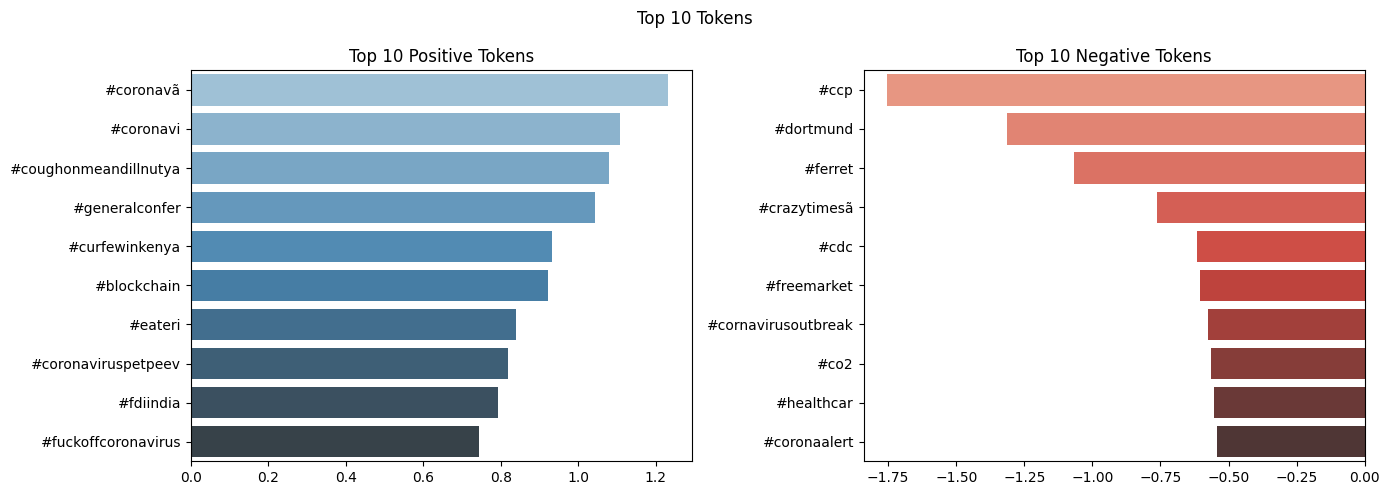

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Создание пайплайна с масштабированием и логистической регрессией
pipeline = make_pipeline(StandardScaler(with_mean=False), LogisticRegression(max_iter=1000))
'''
make_pipeline позволяет объединить несколько шагов обработки данных в один пайплайн.

Масштабирование данных с помощью вычитания среднего значения (with_mean=True) и
последующего деления на стандартное отклонение может привести к тому, что
большинство значений в столбцах разреженной таблицы станут ненулевыми.
Это изменение сделает матрицу плотной, что существенно увеличит объем памяти
'''

# Обучение модели
pipeline.fit(count_features, target)

# Оценка качества модели
train_preds = pipeline.predict(count_features)
test_preds = pipeline.predict(count_features_test)
train_accuracy = accuracy_score(target, train_preds)
test_accuracy = accuracy_score(target_test, test_preds)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Получение коэффициентов модели
coefficients = pipeline.named_steps['logisticregression'].coef_[0]

# Связывание токенов с их коэффициентами
token_coefficients = zip(cv.get_feature_names_out(), coefficients)

# Сортировка токенов по абсолютному значению коэффициентов
sorted_tokens = sorted(token_coefficients, key=lambda x: abs(x[1]), reverse=True)

# Выбор топ-10 положительных и топ-10 отрицательных токенов
top_positive_tokens = [tok for tok, coef in sorted_tokens if coef > 0][:10]
top_negative_tokens = [tok for tok, coef in sorted_tokens if coef < 0][:10]

# Построение barplot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(x=[coef for tok, coef in sorted_tokens if coef > 0][:10], y=top_positive_tokens, ax=ax[0], palette="Blues_d")
ax[0].set_title("Top 10 Positive Tokens")
sns.barplot(x=[coef for tok, coef in sorted_tokens if coef < 0][:10], y=top_negative_tokens, ax=ax[1], palette="Reds_d")
ax[1].set_title("Top 10 Negative Tokens")

plt.suptitle('Top 10 Tokens')
plt.tight_layout()
plt.show()

Проанализируем положительные токены:
1. #coronavã и #coronavi связаны с общими упоминаниями коронавируса. Они отражают нейтральные или информативные сообщения о вирусе.
2. По поводу #coughonmeandillnutya у меня нет предположений. Возможно, это юмористическая фраза.
3. #generalconfer относится к конференциям или обсуждениям, связанным с коронавирусом. Предполагаю, что такой тег ставят организаторы/участники какого-то мероприятия, поэтому подобные твиты отражают информативные и/или позитивные сообщения.
4. #curfewinkenya: комендантский час в Кении как мера предотвращения распространения вируса, что может быть воспринято как необходимая и положительная мера.
5. #blockchain: скорее всего это про технологию, которая могла использоваться для безопасного обмена медицинскими данными, что воспринимается как инновационное решение в кризис.

Проанализируем негативные токены:
1. #ccp: предполагаю, что это китайская коммунистическая партия, которая часто упоминаемая в контексте критики начального ответа на вирус.
2. #dortmund может относиться к событиям или новостям, связанным с этим городом в Германии.
3. #ferret относится к новостям или исследованиям, связанным с хорьками. "Способность хорьков заражаться новым коронавирусом SARS-CoV-2 подтвердили специалисты".
4. #crazytimesã отражает общее чувство неопределенности и стресса во время пандемии.
5. #cdc: центры по контролю и профилактике заболеваний, которые могли быть критикованы за их действия или рекомендации.

Я хочу обратить внимание, что все токены из этих топов являются хэштегами. Это может говорить о том, что именно теги являются наиболее информативными в вопросах об эмоциональной окраске твита.



## Другие признаки

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучим признаки UserName и ScreenName. Полезны ли они?

In [ ]:
print(df.shape[0])
print(df['UserName'].unique().shape[0])

33444
33444


Эти признаки бесполезны по двум причинам.
1. Если бы были сохранены реальные имена, то они могли бы иметь значение. Пример: UserName -- "IHateCoronavirus". Но в базе даны числа, а они неинформативны.
2. Если бы было множество твитов от одних и тех же юзеров, то можно было бы отследить, что какой-то человек чаще пишет позитивные комментарии и на основе этого делать предикт о нем для новых твитов. Но в базе все юзеры уникальны (проверка в коде выше), поэтому этот подход неинформативен.

Изучим признак TweetAt в обучающей выборке: преобразуем его к типу datetime и нарисуем его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он?

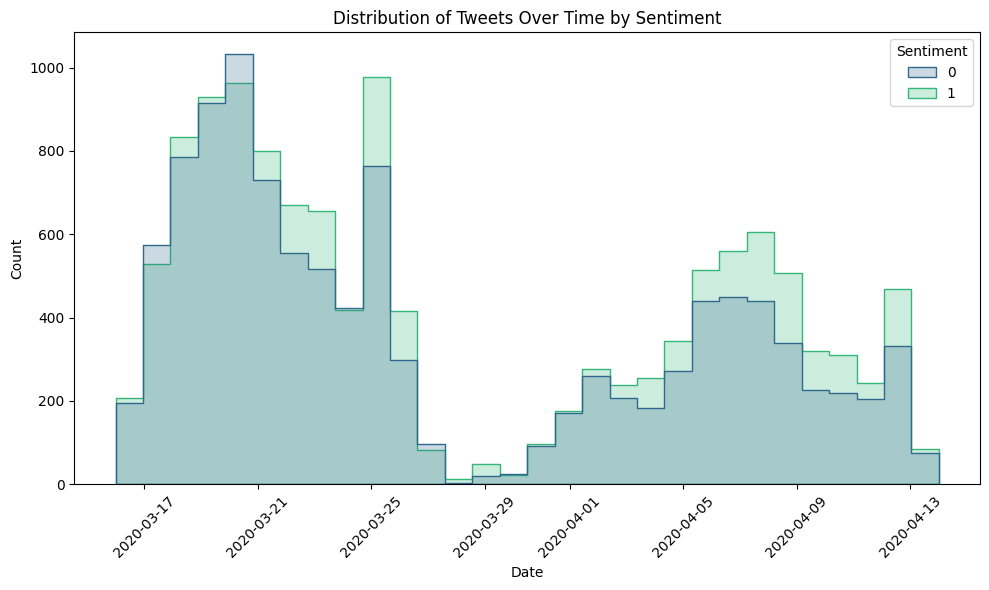

In [ ]:
# Преобразование 'TweetAt' в datetime
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format='%d-%m-%Y')


# Создание гистограммы с разделением по целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='TweetAt', hue='Sentiment', element='step', palette='viridis', bins=30)
plt.title('Distribution of Tweets Over Time by Sentiment')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

График показывает, что количество твитов варьируется от дня к дню. Это может указывать на влияние внешних событий, новостей или развития ситуации с коронавирусом на общественное восприятие и реакции в социальных медиа.

На графике заметны пики и спады активности, которые могут коррелировать с определёнными событиями или изменениями в ходе пандемии. Например, рост числа твитов может быть связан с введением или отменой карантинных мер, важными заявлениями официальных лиц, изменениями в статистике заболеваемости и т.д.

Особые различия в количестве положительных и отрицательных твитов не выявлены. Наличие корреляции между временем и настроением твита не подтверждает причинную связь. Пики в положительных или отрицательных твитах могут быть вызваны внешними событиями, которые не учитываются в дате. А дата -- это всего лишь число. По числу, не имея метаинформации, не удастся сделать даже частичный прогноз.

Также твиты одного дня могут охватывать широкий спектр тем — от новостей о вакцинации до сообщений о новых ограничениях или статистике заболеваемости. Каждое из этих событий может вызывать разные эмоции, которые не улавливаются просто анализом даты.

Модель может переобучиться из-за нюансов конкретных дат в обучающем наборе данных, которые не являются обобщаемыми на новые данные.

К тому же, в столбце TweetAt указывается только дата без времени. Намного интереснее было бы посмотреть на время публикации. Возможно, хейтеры активизируются ближе к вечеру или что-то подобное.

В связи со всем упомянутым выше я считаю этот признак неинформативным.



Поработаем с признаком Location в обучающей выборке. Сколько уникальных значений?

In [ ]:
train['Location'].unique().shape[0]

7949

Построем гистограмму топ-10 по популярности местоположений (исключая Unknown).

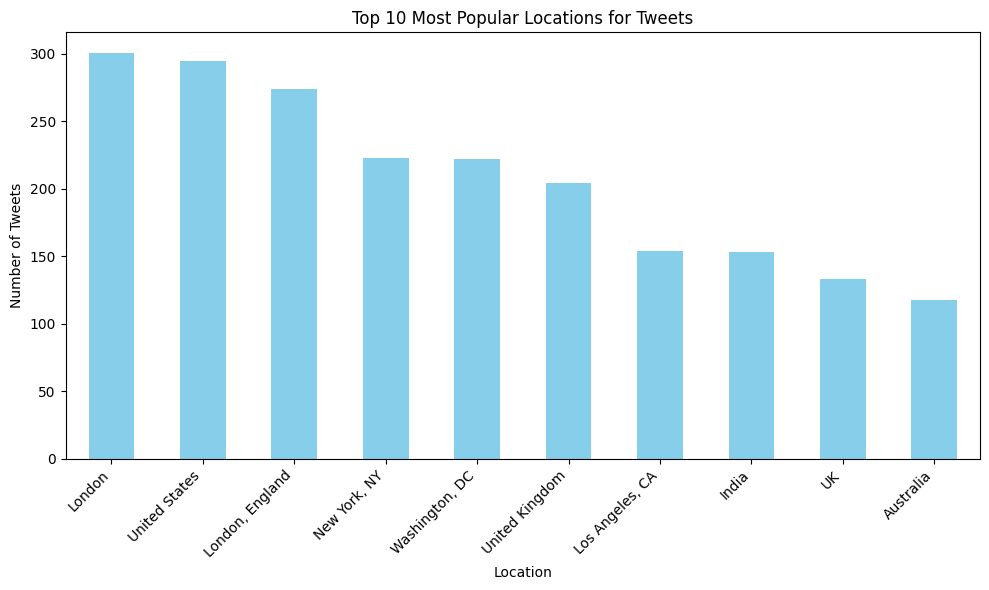

In [ ]:
# Фильтрация записей, где местоположение неизвестно
filtered_train = train[train['Location'] != 'Unknown']

# Подсчет вхождений каждого местоположения
location_counts = filtered_train['Location'].value_counts()

# Выбор топ-10 местоположений
top_locations = location_counts.head(10)

# Создание гистограммы
plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Popular Locations for Tweets')
plt.xlabel('Location')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')  # Поворот меток для лучшей читаемости
plt.tight_layout()
plt.show()

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создадим новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Построем аналогичную гистограмму.

4631


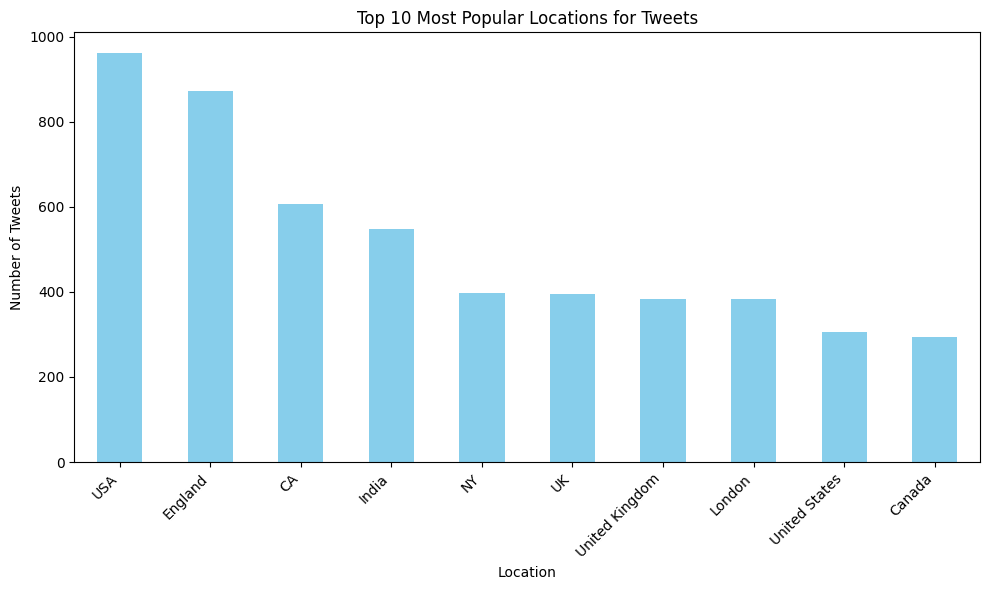

In [ ]:
# Определение функции для извлечения широкого местоположения
def get_wider_location(location):
    if pd.isna(location):
        return "Unknown"
    parts = location.split(',')

    # Возвращаем последний элемент после разделения, который предполагается быть страной или широким регионом
    return parts[-1].strip()
    # strip() используется для удаления начальных и конечных пробелов


# Создание необходимого столбца
train['WiderLocation'] = train['Location'].apply(get_wider_location)

print(train['WiderLocation'].unique().shape[0])

# Фильтрация записей, где местоположение неизвестно
filtered_train = train[train['WiderLocation'] != 'Unknown']

# Подсчет вхождений каждого местоположения
location_counts = filtered_train['WiderLocation'].value_counts()

# Выбор топ-10 местоположений
top_locations = location_counts.head(10)

# Создание гистограммы
plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar', color='skyblue')
plt.title('Top 10 Most Popular Locations for Tweets')
plt.xlabel('Location')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')  # Поворот меток для лучшей читаемости
plt.tight_layout()
plt.show()

Закодируем признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [ ]:
# Фильтруем местоположения, встречающиеся более одного раза
frequent_locations = location_counts[location_counts > 1].index
print(len(location_counts))

# Применяем One-Hot Encoding только к фильтрованному списку местоположений
ohe_df = pd.get_dummies(filtered_train['WiderLocation'])

# Показываем результат кодирования
print(ohe_df.head())

# Создаем столбцы One-Hot Encoding только для часто встречающихся местоположений
ohe_train = pd.get_dummies(train['WiderLocation'])
# Фильтруем столбцы, оставляя только те, которые соответствуют частым местоположениям
ohe_train = ohe_train[frequent_locations]

# Объединяем полученные OHE столбцы с исходным DataFrame
train_extended = pd.concat([train, ohe_train], axis=1)


4630
              \
30135  False   
28899  False   
5989   False   
4367   False   
21350  False   

       "..I had to find the passage back to the place I was before..\r\r\nYou can check-out any time you like\r\r\nBut you can never leave!"  \
30135                                              False                                                                                       
28899                                              False                                                                                       
5989                                               False                                                                                       
4367                                               False                                                                                       
21350                                              False                                                                                       

       "DeviantArt"  #Africa  #Am

Таких значений 4630, уменьшилось всего на 1.

Добавим этот признак к матрице отскалированных текстовых признаков, обучим логистическую регрессию, замерим качество.

In [ ]:
from scipy.sparse import hstack

cv = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11)
train_text = cv.fit_transform(train['OriginalTweet'])
test_text = cv.transform(test['OriginalTweet'])

# Создание необходимого столбца
test['WiderLocation'] = test['Location'].apply(get_wider_location)

# Создаем OHE для тестового набора
ohe_test = pd.get_dummies(test['WiderLocation'])
ohe_train, ohe_test = ohe_train.align(ohe_test, join='inner', axis=1, fill_value=0)

X_train = hstack([train_text, ohe_train])
X_test = hstack([test_text, ohe_test])

model = LogisticRegression(max_iter=1000)
model.fit(X_train, train['Sentiment'])

# Оценка модели
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
train_accuracy = accuracy_score(train['Sentiment'], y_pred_train)
test_accuracy = accuracy_score(test['Sentiment'], y_pred_test)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Train Accuracy: 0.931824006834686
Test Accuracy: 0.8667530396651385


Прошлый результат:
Train Accuracy: 0.9416915847928236
Test Accuracy: 0.8446282639027307

Текущий результат:
Train Accuracy: 0.931824006834686
Test Accuracy: 0.8667530396651385

Результат на тестовой выборке стал лучше, а переобучаемость ниже. Значит, признак полезен для добавления его в анализ.